In [2]:
####### importing all required packages here ##########
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.optimization.algorithms import MinimumEigenOptimizer, GroverOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.aqua import QuantumInstance

In [3]:
from qiskit import IBMQ
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2020-09-30 17:58:21,981: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
############# Creating edge matrix #############

def create_edge_matrix(number_of_points, probability):
    edge_matrix = np.ones((number_of_points,number_of_points))
    for i in range(0,number_of_points):
        for j in range(i,number_of_points):
            if random.random()>probability or i==j:
                edge_matrix[i,j]=0
                edge_matrix[j,i]=0
    return edge_matrix

#create_edge_matrix(5, 0.5)

In [5]:
############ Creating and exporting Quadratic program ############

def Create_quadratic_program(n, edge_matrix):
    qubo = QuadraticProgram()
    linear_coefficients = list()
    summation_terms = dict()
    for i in range(n):
        qubo.binary_var('x'+ str(i))
        linear_coefficients.append(1)
    for i in range(n-1):
        for j in range(i+1,n):
            if edge_matrix[i,j] == 1:
                summation_terms[('x'+str(i),'x'+str(j))] = summation_terms.get(('x'+str(i),'x'+str(j)), -4*n)
    qubo.maximize(linear= linear_coefficients, quadratic= summation_terms)
    #print(qubo.export_as_lp_string())
    #op, offset = qubo.to_ising()
    return qubo
#Create_quadratic_program(5, create_edge_matrix(5,0.5))

In [6]:
######### Solving using NumpyeigenSolver ############

def result_exact(qubo):
    exact_mes = NumPyMinimumEigensolver()
    exact = MinimumEigenOptimizer(exact_mes)
    exact_result = exact.solve(qubo)
    return exact_result.fval
#qubo = Create_quadratic_program(17, create_edge_matrix(17,0.5))
#result_exact(qubo)

############ working fine till 16 only ##############

In [7]:
######### Solving using QAOA ########

def result_qaoa(qubo):
    qaoa_mes = QAOA(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    qaoa_result = qaoa.solve(qubo)
    return qaoa_result.fval
#qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
#result_qaoa(qubo)

In [8]:
####### decimal to binary converter #######

def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    return binary[::-1]
#dec_to_bin(5,4)

In [9]:
######## solving using Brute force ###########

def brute_force(n, edge_matrix):
    best_cost = 0
    best_case =None
    flag = True
    for i in range(2**n):
        binary = dec_to_bin(i,n)
        ans = sum(binary)
        for j in range(n-1):
            for k in range(j+1,n):
                if edge_matrix[j,k]==1:
                    ans = ans - 4*n*binary[j]*binary[k]
        if ans>best_cost:
            best_cost = ans
            #best_case = binary
    return best_cost
#brut_force(8, create_edge_matrix(8,0.5))

In [10]:
########### solving using VQE #########

def using_vqe(qubo):
    vqe = VQE(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qubo)
    return result.fval
#qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
#using_vqe(qubo)

In [11]:
######## solving Using Grover ##########

def using_grover(n,qubo):
    backend = BasicAer.get_backend('qasm_simulator')
    grover_optimizer = GroverOptimizer(n, num_iterations=10, quantum_instance= backend)
    results = grover_optimizer.solve(qubo)
    return results
#qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
#using_grover(5,qubo)

In [12]:
def main_function(n1,n2):
    cost_vs_n = list()
    time_vs_n = list()
    cost_brute = list()
    cost_numpy = list()
    cost_qaoa = list()
    cost_vqe = list()
    time_brute = list()
    time_numpy = list()
    time_qaoa = list()
    time_vqe = list()
    print( "n & brute_force & Numpysolver & QAOA & VQE")
    for i in range(n1,n2):
        for j in range(5):
            adj_matrix = create_edge_matrix(i,0.5)
            qubo = Create_quadratic_program(i, adj_matrix)

            initial_time = time.time()
            cost_brute.append(brute_force(i,adj_matrix))
            final_time = time.time()
            time_brute.append(final_time - initial_time)

            initial_time = time.time()
            cost_numpy.append(result_exact(qubo))
            final_time = time.time()
            time_numpy.append(final_time - initial_time)

            initial_time = time.time()
            cost_qaoa.append(result_qaoa(qubo))
            final_time = time.time()
            time_qaoa.append(final_time - initial_time)

            initial_time = time.time()
            cost_vqe.append(using_vqe(qubo))
            final_time = time.time()
            time_vqe.append(final_time - initial_time)

        (n, cb, cn, cq, cv) = (i, sum(cost_brute)/5.0, sum(cost_numpy)/5.0, sum(cost_qaoa)/5.0, sum(cost_vqe)/5.0)
        (n, tb, tn, tq, tv) = (i, sum(time_brute)/5.0, sum(time_numpy)/5.0, sum(time_qaoa)/5.0, sum(time_vqe)/5.0)

        print(n,'&', cb, '&', tb, '&', cn, '&', tn, '&', cq, '&', tq, '&', cv, '&', tv)    

        cost_vs_n.append((n, cb, cn, cq, cv))
        time_vs_n.append((n, tb, tn, tq, tv))

        cost_brute.clear()
        cost_numpy.clear()
        cost_qaoa.clear()
        cost_vqe.clear()
        time_brute.clear()
        time_numpy.clear()
        time_qaoa.clear()
        time_vqe.clear()

    return cost_vs_n, time_vs_n

In [13]:
cost_vs_n, time_vs_n = main_function(4, 16)

n & brute_force & Numpysolver & QAOA & VQE
4 & 2.2 & 0.0001995086669921875 & 2.2 & 0.0207427978515625 & 2.2 & 0.17335944175720214 & 2.2 & 0.3177331447601318
5 & 3.0 & 0.0006048202514648438 & 3.0 & 0.02173013687133789 & 3.0 & 0.3023987293243408 & 3.0 & 0.6698074340820312
6 & 3.0 & 0.0011908054351806641 & 3.0 & 0.021735095977783205 & 3.0 & 0.46796817779541017 & 2.8 & 2.96725811958313
7 & 3.4 & 0.0033933162689208985 & 3.4 & 0.028522825241088866 & 3.4 & 0.8386634349822998 & 3.4 & 5.809203481674194
8 & 3.4 & 0.008573579788208007 & 3.4 & 0.04148445129394531 & 3.4 & 1.8066370964050293 & 3.2 & 9.474177503585816
9 & 3.6 & 0.026129484176635742 & 3.6 & 0.08178181648254394 & 3.6 & 5.132879066467285 & 3.0 & 40.14076819419861
10 & 4.2 & 0.056458473205566406 & 4.2 & 0.04108448028564453 & 4.2 & 8.18382225036621 & 3.4 & 49.86850438117981
11 & 4.2 & 0.15019779205322265 & 4.2 & 0.05625734329223633 & 4.2 & 9.876882219314576 & 3.8 & 99.80076651573181
12 & 4.2 & 0.25193195343017577 & 4.2 & 0.060231113433837

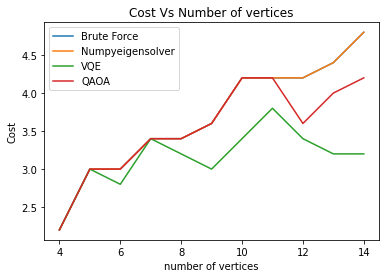

In [17]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
n, cb, cn, cq, cv = zip(*cost_vs_n)
plt.plot(n, cb, label = 'Brute Force')
plt.plot(n, cn, label = 'Numpyeigensolver')
plt.plot(n, cv, label = 'VQE')
plt.plot(n, cq, label = 'QAOA')
plt.legend()


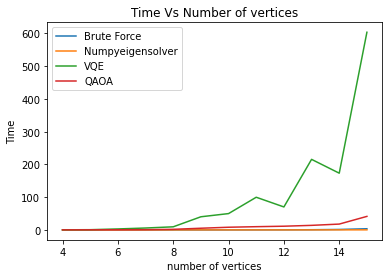

In [18]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
n, tb, tn, tq, tv = zip(*time_vs_n)
plt.plot(n, tb, label = 'Brute Force')
plt.plot(n, tn, label = 'Numpyeigensolver')
plt.plot(n, tv, label = 'VQE')
plt.plot(n, tq, label = 'QAOA')
plt.legend()

In [19]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}